#1.Imports

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!git clone https://github.com/kerkyradim/Music_Recommendation_System_For_Groups.git

Cloning into 'Music_Recommendation_System_For_Groups'...


In [9]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357283 sha256=48efea19b514d55e9bffc0760e73d7843318f8b86d00a8f9250706ec2151829d
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [10]:
pip install datasketch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.2 MB/s eta 0:00:00


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import jaccard_score
import datetime
from surprise import Dataset, Reader, SVD
from surprise import accuracy
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from itertools import product
import heapq
from datasketch import MinHash, MinHashLSH
from random import randrange, uniform

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#2.See data and make the dataset

##2.1 Lastfm dataset

In [15]:
lastfm_df = pd.read_csv('Last.fm_data.csv')
lastfm_df.head()

,Unnamed: 0,Username,Artist,Track,Album,Date,Time
0,0,Babs_05,Isobel Campbell,The Circus Is Leaving Town,Ballad of the Broken Seas,31 Jan 2021,23:36
1,1,Babs_05,Isobel Campbell,Dusty Wreath,Ballad of the Broken Seas,31 Jan 2021,23:32
2,2,Babs_05,Isobel Campbell,Honey Child What Can I Do?,Ballad of the Broken Seas,31 Jan 2021,23:28
3,3,Babs_05,Isobel Campbell,It's Hard To Kill A Bad Thing,Ballad of the Broken Seas,31 Jan 2021,23:25
4,4,Babs_05,Isobel Campbell,Saturday's Gone,Ballad of the Broken Seas,31 Jan 2021,23:21


In [16]:
lastfm_df.drop(['Unnamed: 0'], inplace=True, axis=1)


In [17]:
# Standardize track name and artist columns
lastfm_df['Track'] = lastfm_df['Track'].str.lower().str.strip()
lastfm_df['Artist'] = lastfm_df['Artist'].str.lower().str.strip()

In [18]:
#make lower case the columns names
lastfm_df.columns=lastfm_df.columns.str.lower()

##2.2 Spotify Dataset

In [19]:
spotify_df = pd.read_csv('dataset.csv')
spotify_df.head()

<ipython-input-19-e337b98a33c8>:1: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  spotify_df = pd.read_csv('dataset.csv')


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0.0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4.0,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1.0,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4.0,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1.0,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4.0,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1.0,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3.0,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1.0,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4.0,acoustic


In [20]:
spotify_df.drop(['Unnamed: 0'], inplace=True, axis=1)
(spotify_df.head())

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1.0,-6.746,0.0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4.0,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1.0,-17.235,1.0,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4.0,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0.0,-9.734,1.0,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4.0,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0.0,-18.515,1.0,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3.0,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2.0,-9.681,1.0,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4.0,acoustic


In [21]:
spotify_df['track_name'] = spotify_df['track_name'].str.lower().str.strip()
spotify_df['artists'] = spotify_df['artists'].str.lower().str.strip()

##2.3 See if the datasets have common tracks to merge them

In [22]:
#find common tracks on both dataset and print also the artists on common tracks


common_tracks = set(lastfm_df['track']).intersection(set(spotify_df['track_name']))
if common_tracks:
    print(f"Common tracks: {common_tracks}")
else:
    print("No common tracks found.")

print(len(common_tracks))




Common tracks: {'mia', 'disorder - 2007 remaster', 'violent', 'burn it', 'sick', 'glory box', 'given up', 'this is my life', 'the ocean (feat. shy martin)', 'ready to go', 'cold sweat', 'hereafter', 'choo lo', "movin' out (anthony's song)", 'time capsule', 'mourning palace', 'backyard', 'love explosion', 'perpetual motion', 'death with dignity', 'icky thump', 'her', 'boyz-n-the-hood', 'the future', 'spicy (feat. fivio foreign & a$ap ferg)', '3 gymnopédies: i. lent et douloureux', 'cameo', 'dancing in the moonlight', "mr. highway's thinking about the end", 'wild child', 'gone with the wind', "i'm just a kid", 'my silver lining', "don't forget me", 'clones', 'carnaval', 'let me love you', 'power lines', 'cool water', 'libertango', 'the hardest part', 'just tonight', 'ticket to ride - remastered 2009', 'chemical', 'crying', 'let you down', 'wat zullen we drinken', 'machine gun funk - 2006 remaster', 'falling for you', 'love like this', 'to be alone with you', 'greetings', 'nothing breaks 

##2.4 Display also the artists in common tracks

In [23]:
# Filter datasets for common tracks and then check for matching artists
#common_songs = []

#for t in common_tracks:
    # Get rows from both dataframes where the track names match
    #lastfm_artists = lastfm_df[lastfm_df['Track'] == t]['Artist']
    #spotify_artists = spotify_df[spotify_df['track_name'] == t]['artists']

    # Find common artists for the matched tracks
    #common_artists = set(lastfm_artists).intersection(set(spotify_artists))

    #if common_artists:
        #common_songs.append((t, list(common_artists)))

# Print common tracks with corresponding artists
#if common_songs:
#   print("Common tracks and artists:")
#    for track, artists in common_songs:
#        print(f"Track: {track}, Artists: {', '.join(artists)}")
#else:
#    print("No common tracks with matching artists found.")

# Print total count of common tracks
#print(f"Total common tracks: {len(common_songs)}")


##2.5 merge the 2 datasets in common tracks, artists and albums

In [24]:
# Merge directly on track and artist names (inner join keeps only matching rows)
combined_df = pd.merge(lastfm_df, spotify_df, left_on=['track','artist','album'], right_on=['track_name','artists','album_name'], how='inner')

# Display the merged DataFrame
combined_df.head(15)


,username,artist,track,album,date,time,track_id,artists,album_name,track_name,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,Babs_05,bicep,apricots,Apricots,19 Jan 2021,18:26,73X9X7kDgsm4YeHpc8prf6,bicep,Apricots,apricots,...,-6.778,1.0,0.0390,0.34700,0.824000,0.0830,0.4890,127.986,4.0,ambient
1,Babs_05,christian löffler,ronda,Ronda,19 Jan 2021,17:24,4WyhOKXtCkNVcgfTBpYaxm,christian löffler,Ronda,ronda,...,-15.629,0.0,0.0486,0.67400,0.935000,0.0954,0.1710,119.994,4.0,ambient
2,Babs_05,christian löffler,ronda,Ronda,19 Jan 2021,17:24,4WyhOKXtCkNVcgfTBpYaxm,christian löffler,Ronda,ronda,...,-15.629,0.0,0.0486,0.67400,0.935000,0.0954,0.1710,119.994,4.0,electronic
3,Babs_05,christian löffler,ronda,Ronda,19 Jan 2021,17:24,4WyhOKXtCkNVcgfTBpYaxm,christian löffler,Ronda,ronda,...,-15.629,0.0,0.0486,0.67400,0.935000,0.0954,0.1710,119.994,4.0,french
4,Babs_05,christian löffler,ronda,Ronda,19 Jan 2021,17:24,4WyhOKXtCkNVcgfTBpYaxm,christian löffler,Ronda,ronda,...,-15.629,0.0,0.0486,0.67400,0.935000,0.0954,0.1710,119.994,4.0,minimal-techno
5,Babs_05,christian löffler,ronda,Ronda,19 Jan 2021,17:24,4WyhOKXtCkNVcgfTBpYaxm,christian löffler,Ronda,ronda,...,-15.629,0.0,0.0486,0.67400,0.935000,0.0954,0.1710,119.994,4.0,techno
6,Babs_05,dua lipa,don't start now,Don't Start Now,30 Jan 2021,16:25,6WrI0LAC5M1Rw2MnX2ZvEg,dua lipa,Don't Start Now,don't start now,...,-4.521,0.0,0.0842,0.01250,0.000000,0.0952,0.6770,123.941,4.0,dance
7,Babs_05,eminem,rap god,The Marshall Mathers LP2 (Deluxe),30 Jan 2021,16:19,6or1bKJiZ06IlK0vFvY75k,eminem,The Marshall Mathers LP2 (Deluxe),rap god,...,-2.660,1.0,0.3140,0.39700,0.000000,0.7990,0.6250,148.140,4.0,hip-hop
8,Babs_05,caesars,jerk it out,Jerk It Out,29 Jan 2021,15:26,1bx7OUl2UmAnA5oZkm9If7,caesars,Jerk It Out,jerk it out,...,-2.603,0.0,0.0600,0.01710,0.000011,0.3860,0.8610,134.007,4.0,swedish
9,Babs_05,groove armada,superstylin',Goodbye Country (Hello Nightclub),29 Jan 2021,14:29,2yWyFT6bW1Rd9cjVvYi4v8,groove armada,Goodbye Country (Hello Nightclub),superstylin',...,-8.263,1.0,0.0558,0.00346,0.001310,0.2590,0.9280,128.967,4.0,trip-hop


In [25]:
combined_df.shape

(18083, 26)

In [26]:
#see how many different users do we have
unique_users = combined_df['username'].unique()
print(unique_users)
print(len(unique_users))

['Babs_05' 'franhale' 'eartle' 'massdosage' 'Knapster01' 'jonocole'
 'isaac' 'lobsterclaw' 'jajo' 'mremond' 'Orlenay']
11


In [27]:
combined_df.tail(15)

,username,artist,track,album,date,time,track_id,artists,album_name,track_name,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
18068,Orlenay,hole,violet,Live Through This,31 Jan 2021,23:36,6CHENx8iqzMwavTIz8s0gm,hole,Live Through This,violet,...,-6.493,1.0,0.0469,0.049000,0.000037,0.1840,0.383,167.278,4.0,grunge
18069,Orlenay,hole,violet,Live Through This,31 Jan 2021,23:36,6CHENx8iqzMwavTIz8s0gm,hole,Live Through This,violet,...,-6.493,1.0,0.0469,0.049000,0.000037,0.1840,0.383,167.278,4.0,grunge
18070,Orlenay,pj harvey,when under ether,White Chalk,31 Jan 2021,23:34,6T74sWvcHvSAO5prlk5dDw,pj harvey,White Chalk,when under ether,...,-13.878,0.0,0.0338,0.875000,0.041000,0.1010,0.331,205.079,4.0,psych-rock
18071,Orlenay,kurt cobain,sappy - early demo,Montage Of Heck: The Home Recordings,31 Jan 2021,23:26,4le6DvrwMv2rpyN1SPeL0g,kurt cobain,Montage Of Heck: The Home Recordings,sappy - early demo,...,-19.113,0.0,0.0329,0.437000,0.006410,0.0988,0.172,104.006,4.0,acoustic
18072,Orlenay,kurt cobain,sappy - early demo,Montage Of Heck: The Home Recordings,31 Jan 2021,23:26,4le6DvrwMv2rpyN1SPeL0g,kurt cobain,Montage Of Heck: The Home Recordings,sappy - early demo,...,-19.113,0.0,0.0329,0.437000,0.006410,0.0988,0.172,104.006,4.0,grunge
18073,Orlenay,kurt cobain,sappy - early demo,Montage Of Heck: The Home Recordings,31 Jan 2021,23:26,4le6DvrwMv2rpyN1SPeL0g,kurt cobain,Montage Of Heck: The Home Recordings,sappy - early demo,...,-19.113,0.0,0.0329,0.437000,0.006410,0.0988,0.172,104.006,4.0,grunge
18074,Orlenay,pj harvey,down by the water,To Bring You My Love,31 Jan 2021,22:20,48mJX8glOrQkrSdVBjc0Wb,pj harvey,To Bring You My Love,down by the water,...,-12.255,1.0,0.0412,0.001680,0.181000,0.3430,0.319,125.166,4.0,psych-rock
18075,Orlenay,blind melon,change,Blind Melon,31 Jan 2021,22:11,44RW9FEY76mLQCRQUjT0Zt,blind melon,Blind Melon,change,...,-10.441,1.0,0.0343,0.606000,0.000044,0.1750,0.536,77.525,4.0,grunge
18076,Orlenay,blind melon,change,Blind Melon,31 Jan 2021,22:11,44RW9FEY76mLQCRQUjT0Zt,blind melon,Blind Melon,change,...,-10.441,1.0,0.0343,0.606000,0.000044,0.1750,0.536,77.525,4.0,grunge
18077,Orlenay,hole,malibu,Celebrity Skin,31 Jan 2021,22:07,5bVOX6eyHsML2sB4aMlZEi,hole,Celebrity Skin,malibu,...,-5.854,1.0,0.0343,0.000833,0.000000,0.1740,0.678,122.372,4.0,grunge


#3.Data cleaning

##3.1 See data type for each column

In [28]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18083 entries, 0 to 18082
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   username          18083 non-null  object 
 1   artist            18083 non-null  object 
 2   track             18083 non-null  object 
 3   album             18083 non-null  object 
 4   date              18083 non-null  object 
 5   time              18083 non-null  object 
 6   track_id          18083 non-null  object 
 7   artists           18083 non-null  object 
 8   album_name        18083 non-null  object 
 9   track_name        18083 non-null  object 
 10  popularity        18083 non-null  int64  
 11  duration_ms       18083 non-null  object 
 12  explicit          18083 non-null  object 
 13  danceability      18083 non-null  float64
 14  energy            18083 non-null  float64
 15  key               18083 non-null  float64
 16  loudness          18083 non-null  float6

In [29]:
combined_df.columns

Index(['username', 'artist', 'track', 'album', 'date', 'time', 'track_id',
       'artists', 'album_name', 'track_name', 'popularity', 'duration_ms',
       'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'track_genre'],
      dtype='object')

In [30]:
#delete the same columns
combined_df.drop(['track','artist','album'], axis=1, inplace=True)

In [31]:
#convert to lower case
combined_df.columns=combined_df.columns.str.lower()

In [32]:
#find only the int columns
int_cols=combined_df.columns[(combined_df.dtypes == 'int64') | (combined_df.dtypes=='int32')]

#convert the int cols to float
combined_df[int_cols] = combined_df[int_cols].astype(float)


##3.2 Handling duplicates

In [33]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = combined_df[combined_df.duplicated(keep=False)]
duplicate_rows_index=duplicate_rows.index

In [34]:
#drop all the duplicate
duplicate_rows.shape


(2510, 23)

In [35]:
combined_df= combined_df.drop(duplicate_rows_index)

In [36]:
combined_df.shape

(15573, 23)

##3.3 Complete the rating column

In [37]:
#use popularity to make rating column
max_popularity=combined_df['popularity'].max()
min_popularity=combined_df['popularity'].min()
#scale the ratings from 1-5
combined_df['rating']=1+4*(combined_df['popularity']-min_popularity)/(max_popularity-min_popularity)
combined_df['rating']=combined_df['rating'].round(2)


In [38]:
combined_df.head(20)

,username,date,time,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,rating
0,Babs_05,19 Jan 2021,18:26,73X9X7kDgsm4YeHpc8prf6,bicep,Apricots,apricots,54.0,246506,False,...,1.0,0.0390,0.34700,0.824000,0.0830,0.4890,127.986,4.0,ambient,3.25
1,Babs_05,19 Jan 2021,17:24,4WyhOKXtCkNVcgfTBpYaxm,christian löffler,Ronda,ronda,57.0,346586,False,...,0.0,0.0486,0.67400,0.935000,0.0954,0.1710,119.994,4.0,ambient,3.38
2,Babs_05,19 Jan 2021,17:24,4WyhOKXtCkNVcgfTBpYaxm,christian löffler,Ronda,ronda,57.0,346586,False,...,0.0,0.0486,0.67400,0.935000,0.0954,0.1710,119.994,4.0,electronic,3.38
3,Babs_05,19 Jan 2021,17:24,4WyhOKXtCkNVcgfTBpYaxm,christian löffler,Ronda,ronda,57.0,346586,False,...,0.0,0.0486,0.67400,0.935000,0.0954,0.1710,119.994,4.0,french,3.38
4,Babs_05,19 Jan 2021,17:24,4WyhOKXtCkNVcgfTBpYaxm,christian löffler,Ronda,ronda,57.0,346586,False,...,0.0,0.0486,0.67400,0.935000,0.0954,0.1710,119.994,4.0,minimal-techno,3.38
5,Babs_05,19 Jan 2021,17:24,4WyhOKXtCkNVcgfTBpYaxm,christian löffler,Ronda,ronda,57.0,346586,False,...,0.0,0.0486,0.67400,0.935000,0.0954,0.1710,119.994,4.0,techno,3.38
6,Babs_05,30 Jan 2021,16:25,6WrI0LAC5M1Rw2MnX2ZvEg,dua lipa,Don't Start Now,don't start now,80.0,183290,False,...,0.0,0.0842,0.01250,0.000000,0.0952,0.6770,123.941,4.0,dance,4.42
7,Babs_05,30 Jan 2021,16:19,6or1bKJiZ06IlK0vFvY75k,eminem,The Marshall Mathers LP2 (Deluxe),rap god,78.0,363521,True,...,1.0,0.3140,0.39700,0.000000,0.7990,0.6250,148.140,4.0,hip-hop,4.33
8,Babs_05,29 Jan 2021,15:26,1bx7OUl2UmAnA5oZkm9If7,caesars,Jerk It Out,jerk it out,63.0,195666,False,...,0.0,0.0600,0.01710,0.000011,0.3860,0.8610,134.007,4.0,swedish,3.65
9,Babs_05,29 Jan 2021,14:29,2yWyFT6bW1Rd9cjVvYi4v8,groove armada,Goodbye Country (Hello Nightclub),superstylin',61.0,360426,False,...,1.0,0.0558,0.00346,0.001310,0.2590,0.9280,128.967,4.0,trip-hop,3.56


In [39]:
#see the lines of these names : lobsterclaw' 'jajo'
count_lob = (combined_df['username'] == 'lobsterclaw').sum()
print(count_lob)

#count the lines of these
count_jajo = (combined_df['username'] == 'jajo').sum()
print(count_jajo)


98
98


##3.4 Handling missing values

In [40]:
#See where do we have null values
combined_df.isnull().sum()

,0
username,0
date,0
time,0
track_id,0
artists,0
album_name,0
track_name,0
popularity,0
duration_ms,0
explicit,0


##3.5 Handling with column date

In [41]:
combined_df.columns

Index(['username', 'date', 'time', 'track_id', 'artists', 'album_name',
       'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'rating'],
      dtype='object')

In [42]:
#from date column keep only the year
combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df['date'] = combined_df['date'].dt.year
combined_df.rename(columns={'date': 'year'}, inplace=True)

##3.6 Handling with column time

In [43]:
combined_df['time'] = combined_df['time'].str.strip() #time has leading space
combined_df['time'] = pd.to_datetime(combined_df['time'], format='%H:%M').dt.time

##3.7 See the unique users

In [44]:
#see how many unique users we have
unique_users = combined_df['username'].unique()
print(unique_users)
print(len(unique_users))

#['Babs_05' 'franhale' 'eartle' 'massdosage' 'Knapster01' 'jonocole'
 #'isaac' 'lobsterclaw' 'jajo' 'mremond' 'Orlenay']
#11

['Babs_05' 'franhale' 'eartle' 'massdosage' 'Knapster01' 'jonocole'
 'isaac' 'lobsterclaw' 'jajo' 'mremond' 'Orlenay']
11


##3.8 Handling with column  track id

In [45]:
df_id = pd.DataFrame(enumerate(combined_df['track_id'].unique())).rename({0: 'id', 1: 'track_id'}, axis=1)

In [46]:
df_id.head()

,id,track_id
0,0,73X9X7kDgsm4YeHpc8prf6
1,1,4WyhOKXtCkNVcgfTBpYaxm
2,2,6WrI0LAC5M1Rw2MnX2ZvEg
3,3,6or1bKJiZ06IlK0vFvY75k
4,4,1bx7OUl2UmAnA5oZkm9If7


In [47]:
combined_df['track_id'].head()

,track_id
0,73X9X7kDgsm4YeHpc8prf6
1,4WyhOKXtCkNVcgfTBpYaxm
2,4WyhOKXtCkNVcgfTBpYaxm
3,4WyhOKXtCkNVcgfTBpYaxm
4,4WyhOKXtCkNVcgfTBpYaxm


In [48]:
combined_df=combined_df.merge(df_id)

In [49]:
combined_df.head()

,username,year,time,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,rating,id
0,Babs_05,2021,18:26:00,73X9X7kDgsm4YeHpc8prf6,bicep,Apricots,apricots,54.0,246506,False,...,0.0390,0.347,0.824,0.0830,0.489,127.986,4.0,ambient,3.25,0
1,Babs_05,2021,17:24:00,4WyhOKXtCkNVcgfTBpYaxm,christian löffler,Ronda,ronda,57.0,346586,False,...,0.0486,0.674,0.935,0.0954,0.171,119.994,4.0,ambient,3.38,1
2,Babs_05,2021,17:24:00,4WyhOKXtCkNVcgfTBpYaxm,christian löffler,Ronda,ronda,57.0,346586,False,...,0.0486,0.674,0.935,0.0954,0.171,119.994,4.0,electronic,3.38,1
3,Babs_05,2021,17:24:00,4WyhOKXtCkNVcgfTBpYaxm,christian löffler,Ronda,ronda,57.0,346586,False,...,0.0486,0.674,0.935,0.0954,0.171,119.994,4.0,french,3.38,1
4,Babs_05,2021,17:24:00,4WyhOKXtCkNVcgfTBpYaxm,christian löffler,Ronda,ronda,57.0,346586,False,...,0.0486,0.674,0.935,0.0954,0.171,119.994,4.0,minimal-techno,3.38,1


In [50]:
combined_df['id'][0:5]

,id
0,0
1,1
2,1
3,1
4,1


In [51]:
#delete column track_id
combined_df.drop(['track_id'], axis=1, inplace=True)

In [52]:
#rename id column to track_id
combined_df=combined_df.rename(columns={'id': 'track_id'})

In [53]:
#see the lines of users with names count = (combined_df['username'] == 'lobsterclaw').sum()

count_lob = (combined_df['username'] == 'lobsterclaw').sum()
print(count_lob)



98


In [54]:
unique_users = combined_df['username'].unique()
print(unique_users)
print(len(unique_users))

['Babs_05' 'franhale' 'eartle' 'massdosage' 'Knapster01' 'jonocole'
 'isaac' 'lobsterclaw' 'jajo' 'mremond' 'Orlenay']
11


##3.9 Handling with column genre

In [55]:
df=combined_df.copy()
df.head()

,username,year,time,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,rating,track_id
0,Babs_05,2021,18:26:00,bicep,Apricots,apricots,54.0,246506,False,0.819,...,0.0390,0.347,0.824,0.0830,0.489,127.986,4.0,ambient,3.25,0
1,Babs_05,2021,17:24:00,christian löffler,Ronda,ronda,57.0,346586,False,0.794,...,0.0486,0.674,0.935,0.0954,0.171,119.994,4.0,ambient,3.38,1
2,Babs_05,2021,17:24:00,christian löffler,Ronda,ronda,57.0,346586,False,0.794,...,0.0486,0.674,0.935,0.0954,0.171,119.994,4.0,electronic,3.38,1
3,Babs_05,2021,17:24:00,christian löffler,Ronda,ronda,57.0,346586,False,0.794,...,0.0486,0.674,0.935,0.0954,0.171,119.994,4.0,french,3.38,1
4,Babs_05,2021,17:24:00,christian löffler,Ronda,ronda,57.0,346586,False,0.794,...,0.0486,0.674,0.935,0.0954,0.171,119.994,4.0,minimal-techno,3.38,1


In [56]:
df.shape

(15573, 24)

In [57]:
df_genre = pd.DataFrame(enumerate(df['track_genre'].unique())).rename({0: 'genre', 1: 'track_genre'}, axis=1)

In [58]:
#merge
df=df.merge(df_genre)

In [59]:
# prompt: find lines that all the features are the same except genre , and keep only one line ,with the different genres

# Assuming 'df' is your DataFrame from the previous code
df = df.drop_duplicates(subset=['username', 'track_name', 'artists', 'album_name', 'year', 'time', 'popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'key', 'mode', 'rating', 'track_id'], keep='first')
#If you want to keep only the first occurence of a duplicate,  use keep = 'first'
#If you want to keep only the last occurence of a duplicate, use keep = 'last'
#If you want to drop all the duplicates, use keep = False

In [60]:
df.head()

,username,year,time,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,rating,track_id,genre
0,Babs_05,2021,18:26:00,bicep,Apricots,apricots,54.0,246506,False,0.819,...,0.3470,0.824000,0.0830,0.489,127.986,4.0,ambient,3.25,0,0
1,Babs_05,2021,17:24:00,christian löffler,Ronda,ronda,57.0,346586,False,0.794,...,0.6740,0.935000,0.0954,0.171,119.994,4.0,ambient,3.38,1,0
6,Babs_05,2021,16:25:00,dua lipa,Don't Start Now,don't start now,80.0,183290,False,0.794,...,0.0125,0.000000,0.0952,0.677,123.941,4.0,dance,4.42,2,5
7,Babs_05,2021,16:19:00,eminem,The Marshall Mathers LP2 (Deluxe),rap god,78.0,363521,True,0.708,...,0.3970,0.000000,0.7990,0.625,148.140,4.0,hip-hop,4.33,3,6
8,Babs_05,2021,15:26:00,caesars,Jerk It Out,jerk it out,63.0,195666,False,0.580,...,0.0171,0.000011,0.3860,0.861,134.007,4.0,swedish,3.65,4,7


In [61]:
df.shape

(10847, 25)

##3.10 Label Encoding for column 'artists', 'album_name' and 'username'

In [62]:

le_artist = LabelEncoder()
df['artists'] = le_artist.fit_transform(df['artists'])

le_album = LabelEncoder()
df['album_name'] = le_album.fit_transform(df['album_name'])

le_username = LabelEncoder()
df['username'] = le_album.fit_transform(df['username'])


In [63]:
df['artists'][0:5]


,artists
0,147
1,263
6,381
7,415
8,224


In [64]:
df['username'][0:5]

,username
0,0
1,0
6,0
7,0
8,0


In [65]:
df['album_name'][0:5]

,album_name
0,150
1,1456
6,493
7,1800
8,913


##3.11 Info about the final data frame

In [66]:
df.head()

,username,year,time,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,rating,track_id,genre
0,0,2021,18:26:00,147,150,apricots,54.0,246506,False,0.819,...,0.3470,0.824000,0.0830,0.489,127.986,4.0,ambient,3.25,0,0
1,0,2021,17:24:00,263,1456,ronda,57.0,346586,False,0.794,...,0.6740,0.935000,0.0954,0.171,119.994,4.0,ambient,3.38,1,0
6,0,2021,16:25:00,381,493,don't start now,80.0,183290,False,0.794,...,0.0125,0.000000,0.0952,0.677,123.941,4.0,dance,4.42,2,5
7,0,2021,16:19:00,415,1800,rap god,78.0,363521,True,0.708,...,0.3970,0.000000,0.7990,0.625,148.140,4.0,hip-hop,4.33,3,6
8,0,2021,15:26:00,224,913,jerk it out,63.0,195666,False,0.580,...,0.0171,0.000011,0.3860,0.861,134.007,4.0,swedish,3.65,4,7


In [67]:
df.dtypes

,0
username,int64
year,int32
time,object
artists,int64
album_name,int64
track_name,object
popularity,float64
duration_ms,object
explicit,object
danceability,float64


In [68]:
#find only the int columns
int_cols=df.columns[(df.dtypes == 'int64') | (df.dtypes=='int32')]

#convert the int cols to float
df[int_cols] = df[int_cols].astype(float)


In [69]:
df.isna().sum()

,0
username,0
year,0
time,0
artists,0
album_name,0
track_name,0
popularity,0
duration_ms,0
explicit,0
danceability,0


In [70]:
df.shape

(10847, 25)

#4.Groups making

##4.1 Cross tab between users and songs

In [71]:
#crosstab to see which user has listend which song
user_song_df = pd.crosstab(df['username'], df['track_id'])
user_song_df.head()

track_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,3123.0,3124.0,3125.0,3126.0,3127.0,3128.0,3129.0,3130.0,3131.0,3132.0
username,,,,,,,,,,,,,,,,,,,,,
0.0,4,1,4,2,2,1,2,1,2,3,...,0,0,0,0,0,0,0,0,0,0
1.0,2,0,1,0,1,0,3,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2.0,0,0,2,0,0,0,1,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3.0,1,0,0,0,0,0,2,0,1,2,...,0,0,0,0,0,0,0,0,0,0
4.0,1,1,3,0,0,0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
user_song_df.shape

(11, 3133)

##4.2 Jaccard similarity function for users

In [73]:
#jaccard similarity between 2 users
def jaccard_similarity(user1, user2,matrix):
  return jaccard_score(matrix.loc[user1.name], matrix.loc[user2.name], average='macro')

##4.3 3-user groups based on jaccard similarity

In [74]:
#make 3-users groups
groups=[]
for user_comb in itertools.combinations(user_song_df.index, 3):
  u1,u2,u3=user_comb #make all the possible combinations
  sim_u1_u2=jaccard_similarity(user_song_df.loc[u1],user_song_df.loc[u2],user_song_df)
  sim_u1_u3=jaccard_similarity(user_song_df.loc[u1],user_song_df.loc[u3],user_song_df)
  sim_u2_u3=jaccard_similarity(user_song_df.loc[u2],user_song_df.loc[u3],user_song_df)

  avg_similarity=(sim_u1_u2+sim_u1_u3+sim_u2_u3)/3
  if avg_similarity>0.2:
    groups.append((u1,u2,u3))
print(groups)


[(0.0, 5.0, 6.0), (0.0, 5.0, 8.0), (0.0, 6.0, 8.0), (0.0, 6.0, 10.0), (0.0, 8.0, 10.0), (1.0, 5.0, 6.0), (1.0, 5.0, 8.0), (1.0, 6.0, 8.0), (1.0, 6.0, 10.0), (1.0, 8.0, 10.0), (2.0, 5.0, 6.0), (2.0, 5.0, 8.0), (2.0, 5.0, 10.0), (2.0, 6.0, 8.0), (2.0, 6.0, 10.0), (2.0, 8.0, 10.0), (3.0, 5.0, 6.0), (3.0, 5.0, 8.0), (3.0, 5.0, 10.0), (3.0, 6.0, 8.0), (3.0, 6.0, 10.0), (3.0, 8.0, 10.0), (4.0, 6.0, 8.0), (4.0, 6.0, 10.0), (4.0, 8.0, 10.0), (5.0, 6.0, 7.0), (5.0, 6.0, 8.0), (5.0, 6.0, 9.0), (5.0, 6.0, 10.0), (5.0, 7.0, 8.0), (5.0, 7.0, 10.0), (5.0, 8.0, 9.0), (5.0, 8.0, 10.0), (6.0, 7.0, 8.0), (6.0, 7.0, 10.0), (6.0, 8.0, 9.0), (6.0, 8.0, 10.0), (6.0, 9.0, 10.0), (7.0, 8.0, 10.0), (8.0, 9.0, 10.0)]


##4.4 Attempt with Minhash LSH for creating the groups

In [75]:
def convert_crosstab_in_set_for_every_user(user_song_df):
  user_songs_dict={}
  for user in user_song_df.index:
    #print(user)
    #make a set for every user
    user_songs=set()
    for song in user_song_df.columns:
      if user_song_df.loc[user,song]>0:
        #print(song)
        #put th id of the song in the set
        user_songs.add(song)
    user_songs_dict[user]=user_songs
    #print(f"User {user} has listened to: {user_songs}")
  return user_songs_dict


In [76]:
user_songs_dict=convert_crosstab_in_set_for_every_user(user_song_df)

In [77]:
print(user_songs_dict[1])

{0.0, 2.0, 2050.0, 4.0, 2053.0, 6.0, 2850.0, 8.0, 9.0, 2851.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 2067.0, 2068.0, 21.0, 2446.0, 2852.0, 2447.0, 2853.0, 2854.0, 28.0, 2076.0, 2525.0, 36.0, 37.0, 2085.0, 2086.0, 46.0, 47.0, 2094.0, 2859.0, 50.0, 51.0, 2101.0, 56.0, 58.0, 2861.0, 2526.0, 65.0, 66.0, 2866.0, 2456.0, 70.0, 2119.0, 73.0, 2457.0, 2864.0, 77.0, 78.0, 2865.0, 81.0, 2129.0, 2130.0, 2131.0, 2132.0, 2133.0, 2134.0, 2135.0, 2136.0, 2137.0, 2138.0, 2527.0, 93.0, 2461.0, 95.0, 2867.0, 2145.0, 2868.0, 99.0, 100.0, 101.0, 2150.0, 2151.0, 104.0, 2152.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 2161.0, 117.0, 2162.0, 2165.0, 2167.0, 2168.0, 2466.0, 123.0, 2528.0, 125.0, 2873.0, 2874.0, 128.0, 2875.0, 131.0, 132.0, 2180.0, 134.0, 135.0, 2876.0, 138.0, 2877.0, 140.0, 2529.0, 142.0, 144.0, 2192.0, 2878.0, 147.0, 149.0, 2198.0, 151.0, 152.0, 2201.0, 154.0, 2879.0, 2204.0, 2880.0, 159.0, 2881.0, 162.0, 164.0, 2530.0, 2869.0, 170.0, 171.0, 2223.0, 2884.0, 17

In [78]:
minhashes = {}
for user, songs in user_songs_dict.items():
    m = MinHash(num_perm=128)
    for song in songs:
        m.update(str(song).encode('utf8'))
    minhashes[user] = m

#LSH
lsh = MinHashLSH(threshold=0.2,num_perm=128)
for user, mh in minhashes.items():
    lsh.insert(user, mh)

In [79]:
for user in user_songs_dict.keys():
  #print(user)
  similar_users = lsh.query(minhashes[user])
  print(f"Similar to user {user}: {similar_users}")


Similar to user 0.0: [0.0, 1.0, 2.0, 3.0, 4.0, 7.0, 9.0]
Similar to user 1.0: [0.0, 1.0, 3.0, 4.0, 7.0]
Similar to user 2.0: [0.0, 9.0, 2.0, 3.0]
Similar to user 3.0: [0.0, 1.0, 2.0, 3.0, 4.0, 7.0, 9.0]
Similar to user 4.0: [0.0, 1.0, 3.0, 4.0, 7.0, 9.0]
Similar to user 5.0: [8.0, 10.0, 5.0, 6.0]
Similar to user 6.0: [8.0, 10.0, 5.0, 6.0]
Similar to user 7.0: [0.0, 1.0, 3.0, 4.0, 7.0, 9.0]
Similar to user 8.0: [8.0, 10.0, 5.0, 6.0]
Similar to user 9.0: [0.0, 2.0, 3.0, 4.0, 7.0, 9.0]
Similar to user 10.0: [8.0, 10.0, 5.0, 6.0]


##4.5 find the best parameters in LSH Minhash

In [80]:
print(user_songs_dict)

{0.0: {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.

In [81]:
#jaccard similarity for a set of users
def calculate_jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2)

# reference data for evaluation
reference_data = {}
users = list(user_songs_dict.keys())
for i in range(len(users)):
    for j in range(i + 1, len(users)):
        similarity = calculate_jaccard_similarity(user_songs_dict[users[i]], user_songs_dict[users[j]])
        reference_data[(users[i], users[j])] = similarity
        #reference_data[(users[j], users[i])] = similarity


In [82]:
def evaluate_with_reference(lsh, reference_data, minhashes):
    scores = []
    for (user1, user2), ref_score in reference_data.items():
        #find the similar users using LSH
        similar_users = set(lsh.query(minhashes[user1]))
        is_similar = 1 if user2 in similar_users else 0
        scores.append((ref_score, is_similar))
    return scores

In [83]:
#parameter grid search space
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
permutations = [32, 64, 128, 256]

best_threshold = None
best_permutation = None
best_score = -1  #initialize with a low value


results=[]

for threshold, num_perm in product(thresholds, permutations):
    #create minhash objects
    minhashes = {}
    for user, songs in user_songs_dict.items():
        m = MinHash(num_perm=num_perm)
        for song in songs:
            m.update(str(song).encode('utf8'))
        minhashes[user] = m

    # Create LSH index
    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
    for user, mh in minhashes.items():
        lsh.insert(user, mh)

    #print the number of buckets an drows in lsh minhash
    #print(f"Number of buckets: {lsh.b}, Number of rows: {lsh.r}")

    # Evaluate
    scores = evaluate_with_reference(lsh, reference_data, minhashes)

    # Calculate evaluation metrics (e.g., precision, recall, F1-score, accuracy)
    true_positives = sum(1 for ref_score, is_similar in scores if ref_score > 0.5 and is_similar == 1)
    false_positives = sum(1 for ref_score, is_similar in scores if ref_score <= 0.5 and is_similar == 1)
    false_negatives = sum(1 for ref_score, is_similar in scores if ref_score > 0.5 and is_similar == 0)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0


    correct_predictions = sum(1 for ref, pred in scores if (ref > 0.2 and pred == 1) or (ref <=0.2 and pred == 0))
    accuracy = correct_predictions / len(scores)


    print(f"Threshold: {threshold}, Permutations: {num_perm}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    print(f"F1-score: {f1_score:.4f}, Accuracy: {accuracy:.4f}")


    #take into account also the accuracy
    if accuracy > best_score:
        best_score = accuracy
        best_threshold = threshold
        best_permutation = num_perm


    results.append({
        "threshold": threshold,
        "num_perm": num_perm,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "accuracy": accuracy
    })

print(f"\nBest Threshold: {best_threshold}, Best Permutations: {best_permutation}, Best Accuracy: {best_score}")

Threshold: 0.1, Permutations: 32, Precision: 0.1282, Recall: 1.0000
F1-score: 0.2273, Accuracy: 0.7273
Threshold: 0.1, Permutations: 64, Precision: 0.1282, Recall: 1.0000
F1-score: 0.2273, Accuracy: 0.7273
Threshold: 0.1, Permutations: 128, Precision: 0.1786, Recall: 1.0000
F1-score: 0.3030, Accuracy: 0.9273
Threshold: 0.1, Permutations: 256, Precision: 0.1389, Recall: 1.0000
F1-score: 0.2439, Accuracy: 0.7818
Threshold: 0.2, Permutations: 32, Precision: 0.2381, Recall: 1.0000
F1-score: 0.3846, Accuracy: 0.9455
Threshold: 0.2, Permutations: 64, Precision: 0.2174, Recall: 1.0000
F1-score: 0.3571, Accuracy: 0.9455
Threshold: 0.2, Permutations: 128, Precision: 0.2174, Recall: 1.0000
F1-score: 0.3571, Accuracy: 0.9455
Threshold: 0.2, Permutations: 256, Precision: 0.2273, Recall: 1.0000
F1-score: 0.3704, Accuracy: 0.9273
Threshold: 0.3, Permutations: 32, Precision: 0.2941, Recall: 1.0000
F1-score: 0.4545, Accuracy: 0.8727
Threshold: 0.3, Permutations: 64, Precision: 0.3846, Recall: 1.0000
F

In [84]:
# Convert results to a dataframe
results_df = pd.DataFrame(results)

In [85]:
results_df.head(5)

,threshold,num_perm,precision,recall,f1_score,accuracy
0,0.1,32,0.128205,1.0,0.227273,0.727273
1,0.1,64,0.128205,1.0,0.227273,0.727273
2,0.1,128,0.178571,1.0,0.303030,0.927273
3,0.1,256,0.138889,1.0,0.243902,0.781818
4,0.2,32,0.238095,1.0,0.384615,0.945455


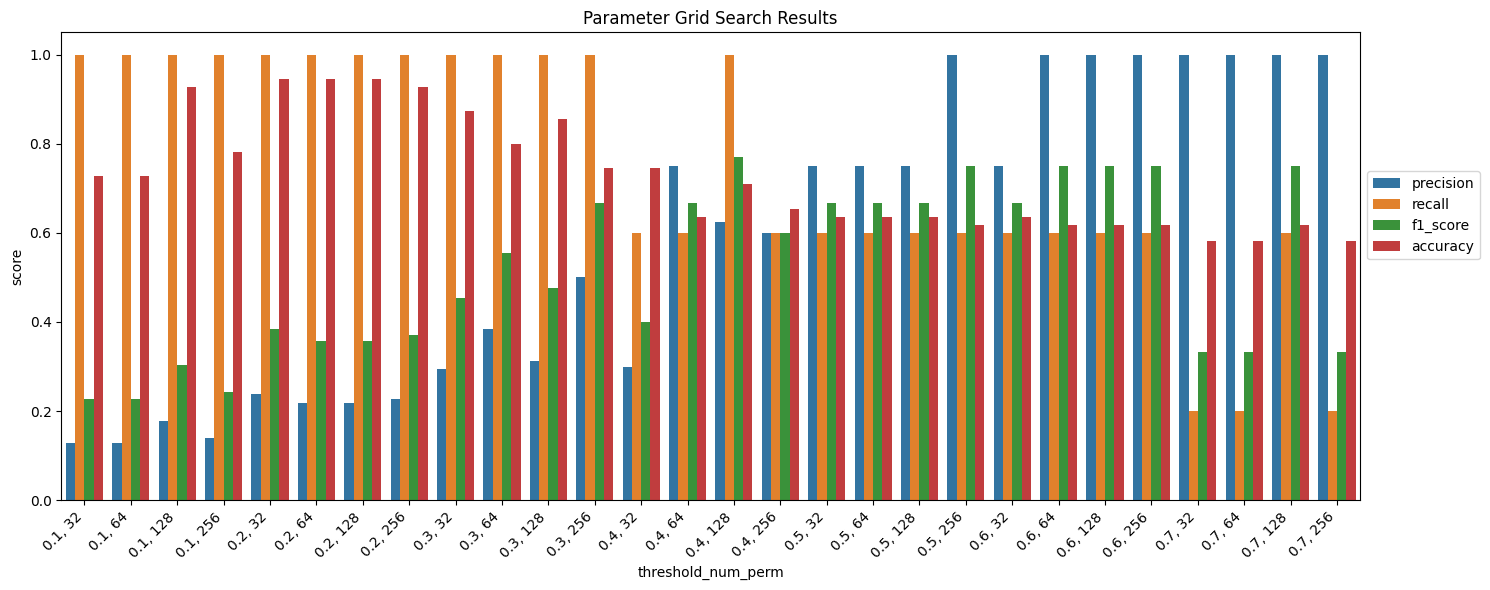

In [86]:

# Melt the DataFrame to combine 'threshold' and 'num_perm' into a single column
melted_df = pd.melt(results_df, id_vars=['threshold', 'num_perm'],
                    value_vars=['precision', 'recall', 'f1_score', 'accuracy'],
                    var_name='metric', value_name='score')

# Create a new column combining 'threshold' and 'num_perm'
melted_df['threshold_num_perm'] = melted_df['threshold'].astype(str) + ', ' + melted_df['num_perm'].astype(str)

# Create the grouped bar plot using seaborn
plt.figure(figsize=(15, 6))
sns.barplot(x='threshold_num_perm', y='score', hue='metric',
            data=melted_df, errorbar=None)
plt.title('Parameter Grid Search Results')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##4.6 Jaccard Similarity vs LSH Probabillity visualization

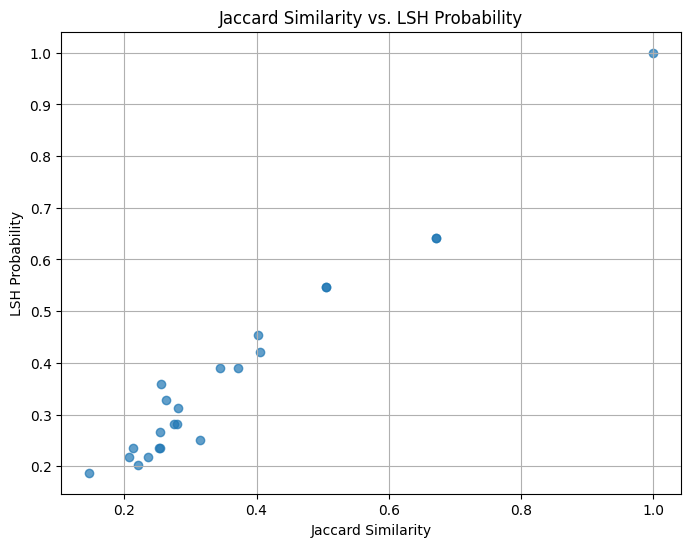

In [87]:
#initialize minhashses
num_perm = 64
minhashes = {}
for user, songs in user_songs_dict.items():
    m = MinHash(num_perm=num_perm)
    for song in songs:
        m.update(str(song).encode('utf8'))
    minhashes[user] = m

# Initialize LSH
threshold = 0.2
lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
for user, mh in minhashes.items():
    lsh.insert(user, mh)

#get candidate pairs by quering the keys for similar users
candidate_pairs = []
for user in user_songs_dict.keys():
    for other_user in lsh.query(minhashes[user]):
        if user != other_user and (other_user, user) not in candidate_pairs:  # Avoid duplicates
            candidate_pairs.append((user, other_user))

#calculate jaccard similarity and lsh probs f every pair
jaccard_similarities = []
lsh_probabilities = []

for user1, user2 in candidate_pairs:
    set1 = user_songs_dict[user1]
    set2 = user_songs_dict[user2]

    # Jaccard similarity
    jaccard = calculate_jaccard_similarity(set1, set2)
    jaccard_similarities.append(jaccard)

    # LSH probability (approximated as MinHash similarity)
    mh1 = minhashes[user1]
    mh2 = minhashes[user2]
    lsh_prob = mh1.jaccard(mh2)
    lsh_probabilities.append(lsh_prob)

# Plot Jaccard similarity vs. LSH probability
plt.figure(figsize=(8, 6))
plt.scatter(jaccard_similarities, lsh_probabilities, alpha=0.7)

plt.xlabel("Jaccard Similarity")
plt.ylabel("LSH Probability")
plt.title("Jaccard Similarity vs. LSH Probability")

plt.grid(True)
plt.show()

#5.Make model and train

##5.1 Compute user_weights based on the songs that have heard

In [88]:
user_weights=df.groupby('username')['track_id'].count()

#scale them to (0,1)
user_weights=user_weights/user_weights.max()
user_weights


,track_id
username,
0.0,0.844516
1.0,0.714343
2.0,0.225793
3.0,0.534351
4.0,1.000000
5.0,0.059060
6.0,0.029329
7.0,0.466452
8.0,0.029329


##5.2 Train an SVD model for every user


In [89]:
reader=Reader(rating_scale=(1, 5))
#for every group
group_suggestions=[]#list for the suggestions of the group
for group in groups:
  group_recommendations={} #dictionary to store predictions for every user with weights
                           #in the group

  #for each user train and fit and svd algorithm
  for user in group:

    #filter train data for every user
    user_data=df[df['username']==user]


    #Create a DataFrame for Surprise package in the form [username, track_id, rating]
    user_surprise_data=user_data[['username', 'track_id', 'rating']]

    #fit
    data=Dataset.load_from_df(user_surprise_data, reader)
    trainset = data.build_full_trainset()
    svd = SVD()
    svd.fit(trainset)

    #predict
    predictions_train=svd.test(trainset.build_testset())
    #print(f"Group:", group)
    #print(predictions_train)

    #evaluate the prediction
    #accuracy.mse(predictions_train)

    #unseen tracks of the user
    unseen_tracks =df[~df['track_id'].isin(user_data['track_id'])]['track_id'].unique()
    #print(unseen_tracks)

    for track in unseen_tracks:
      #predict if match
      prediction = svd.predict(user, track)
      if track not in group_recommendations:
        group_recommendations[track]=[] #if the song does not included in the list, make a list for that
      group_recommendations[track].append((prediction.est,user_weights[user])) #append in the list the estimation and its weights


  #[(2.3476610548908505, 0.02952565343659245),
  #(2.7481380706904295, 0.5024201355275896),
  #(2.393017557153354, 0.036786060019361085)])
  #compute the weighted average for unseen items
  final_recommendations={}
  for track,predictions in group_recommendations.items():
    total_weight=0
    weighted_sum=0
    for prediction,weight in predictions:
      weighted_sum+=prediction*weight
      total_weight+=weight
    final_recommendations[track]=weighted_sum/total_weight

  #append in group_recommendations
  group_suggestions.append(sorted(final_recommendations.items(), key=lambda x: x[1], reverse=True)[:10])







In [90]:
#print the top-10 suggestions for evefry group
for i, recommendations in enumerate(group_suggestions):
  print(f"Group {i},{recommendations}")

Group 0,[(1405.0, 3.641597561288877), (1406.0, 3.641597561288877), (1479.0, 3.641597561288877), (1818.0, 3.641597561288877), (2085.0, 3.641597561288877), (2138.0, 3.641597561288877), (2434.0, 3.641597561288877), (2435.0, 3.641597561288877), (2436.0, 3.641597561288877), (2437.0, 3.641597561288877)]
Group 1,[(1405.0, 3.641527679008554), (1406.0, 3.641527679008554), (1479.0, 3.641527679008554), (1818.0, 3.641527679008554), (2085.0, 3.641527679008554), (2138.0, 3.641527679008554), (2434.0, 3.641527679008554), (2435.0, 3.641527679008554), (2436.0, 3.641527679008554), (2437.0, 3.641527679008554)]
Group 2,[(1405.0, 3.6290252670264045), (1406.0, 3.6290252670264045), (1479.0, 3.6290252670264045), (1818.0, 3.6290252670264045), (2085.0, 3.6290252670264045), (2138.0, 3.6290252670264045), (2434.0, 3.6290252670264045), (2435.0, 3.6290252670264045), (2436.0, 3.6290252670264045), (2437.0, 3.6290252670264045)]
Group 3,[(1405.0, 3.625318065856763), (1406.0, 3.625318065856763), (1479.0, 3.625318065856763

##5.3 Evaluation /Coverage

In [91]:
def coverage(group_suggestions,group_data,threshold):
  coverage_scores=[]

  for i,recommendations in enumerate(group_suggestions):
   # print(i)
    group=groups[i]

    coverage_leiked_by_all=0
    coverage_leiked_by_most=0
    total_recommendations=len(recommendations)

    for track, _ in recommendations:
      #see how many users have rated the song  >= threshold
      likes=sum(1 for user in group if svd.predict(user,track).est>=threshold)

      if likes==len(group):
        coverage_leiked_by_all+=1

      if likes>=(len(group)//2): #if hald of users in the group liked the song
        coverage_leiked_by_most+=1


    coverage_scores.append((coverage_leiked_by_all/total_recommendations,
                            coverage_leiked_by_most/total_recommendations))

  return coverage_scores


In [92]:
group_data=[]
for group in groups:
  group_data.append(df[df['username'].isin(groups[0])])
#group_data[0].head()

In [93]:
coverage_scores=coverage(group_suggestions,group_data,3.5)


In [94]:
for i,group in enumerate (groups):
  print(f"Group {i}:")
  print(f"Coverage liked by all: {coverage_scores[groups.index(group)][0]}")
  print(f"Coverage liked by most: {coverage_scores[groups.index(group)][1]}")

Group 0:
Coverage liked by all: 0.8
Coverage liked by most: 0.8
Group 1:
Coverage liked by all: 0.8
Coverage liked by most: 0.8
Group 2:
Coverage liked by all: 0.8
Coverage liked by most: 0.8
Group 3:
Coverage liked by all: 0.6
Coverage liked by most: 0.8
Group 4:
Coverage liked by all: 0.6
Coverage liked by most: 0.8
Group 5:
Coverage liked by all: 0.8
Coverage liked by most: 0.8
Group 6:
Coverage liked by all: 0.8
Coverage liked by most: 0.8
Group 7:
Coverage liked by all: 0.8
Coverage liked by most: 0.8
Group 8:
Coverage liked by all: 0.4
Coverage liked by most: 0.8
Group 9:
Coverage liked by all: 0.4
Coverage liked by most: 0.8
Group 10:
Coverage liked by all: 0.9
Coverage liked by most: 0.9
Group 11:
Coverage liked by all: 0.9
Coverage liked by most: 0.9
Group 12:
Coverage liked by all: 0.4
Coverage liked by most: 0.9
Group 13:
Coverage liked by all: 0.9
Coverage liked by most: 0.9
Group 14:
Coverage liked by all: 0.4
Coverage liked by most: 0.9
Group 15:
Coverage liked by all: 0.

##5.4 Evaluation/Diversity

In [95]:
#measure evaluation across diveristy
def diversity(group_suggestions, df):
  diversity_scores=[]

  for group_recs in group_suggestions:
    track_ids = [id for id,_ in group_recs]

    #Handle where there are no track_ids
    if not track_ids:
      diversity_scores.append(0)
      continue

    #create a matrix where rows are songs ids and columns are features
    song_features_df=df.loc[df['track_id'].isin(track_ids), ['track_id', 'artists', 'album_name']].drop_duplicates()


    diversity_score = 0
    #Comparison between genres

    for i in range(len(track_ids) - 1):
      for j in range(i + 1, len(track_ids)):
        #compare pairwise genres
        song1_features = song_features_df[song_features_df['track_id'] == track_ids[i]]['album_name'].values
        song2_features = song_features_df[song_features_df['track_id'] == track_ids[j]]['album_name'].values

        #if the 2 songs are valid and different
        if song1_features.size > 0 and song2_features.size > 0 and song1_features[0] != song2_features[0]:
          diversity_score += 1

          #final diveristy score is computed as the number of diverse pairs
          #devided by the total number of possible pairs of tracks (n(n-1)/2)
          #if there is only one track the diversity is max,1

    diversity_scores.append(diversity_score / (len(track_ids) * (len(track_ids) - 1) / 2) if len(track_ids) > 1 else 1)
  return diversity_scores


In [96]:
diversity_scores=diversity(group_suggestions,df)

In [97]:
# Print diversity scores for each group
for i, diversity_score in enumerate(diversity_scores):
  print(f"Group {i + 1}: Diversity Score = {diversity_score:.4f}")


Group 1: Diversity Score = 0.9778
Group 2: Diversity Score = 0.9778
Group 3: Diversity Score = 0.9778
Group 4: Diversity Score = 0.9778
Group 5: Diversity Score = 0.9778
Group 6: Diversity Score = 0.9778
Group 7: Diversity Score = 0.9778
Group 8: Diversity Score = 0.9778
Group 9: Diversity Score = 0.9778
Group 10: Diversity Score = 0.9778
Group 11: Diversity Score = 0.9778
Group 12: Diversity Score = 0.9778
Group 13: Diversity Score = 0.9778
Group 14: Diversity Score = 0.9778
Group 15: Diversity Score = 0.9778
Group 16: Diversity Score = 0.9778
Group 17: Diversity Score = 0.9778
Group 18: Diversity Score = 0.9778
Group 19: Diversity Score = 0.9778
Group 20: Diversity Score = 1.0000
Group 21: Diversity Score = 0.9778
Group 22: Diversity Score = 0.9778
Group 23: Diversity Score = 1.0000
Group 24: Diversity Score = 0.9778
Group 25: Diversity Score = 0.9778
Group 26: Diversity Score = 0.9778
Group 27: Diversity Score = 1.0000
Group 28: Diversity Score = 0.9778
Group 29: Diversity Score = 0

##5.5 Evaluation/Consensus

Αξιολογεί σε ποιο βαθμό τα μέλη της ομάδας έχουν καταλήξει σε συμφωνία σε σχέση με τις προτεινόμενες προτάσεις.

In [98]:
def consensus(group_recommendations, tracks,max_rating=5):

  track_consensus_scores={}

  for track, l in group_recommendations.items():

    #extract only the rating from the group recommendations
    #ignoring the weights
    predicted_ratings=[pred for pred, _ in l]

    #calclulate the pairwise absolute differences in predicted ratings
    pairwise_diffs=[]
    #print(f"predicted_ratings {predicted_ratings}")
    #print(f"len of predicted_ratings {len(predicted_ratings)}")
    if len(predicted_ratings)<2:
      continue
    for i in range(len(predicted_ratings)-1):
      for j in range(i+1,len(predicted_ratings)):
        #print(pairwise_diffs)
        diff=abs(predicted_ratings[i]-predicted_ratings[j])
        #print(f"diff {diff}")
        pairwise_diffs.append(diff)

    #average pairwise differenses
    avg_pairwise_diff=sum(pairwise_diffs)/len(pairwise_diffs)

    #calculate consensus score
    consensus_score=1-avg_pairwise_diff/(max_rating * (len(group)-1)/2)

    track_consensus_scores[track]=consensus_score

  return track_consensus_scores

In [99]:
#group_suggestions is a list where each element corresponds to a list of recommended tracks for a group
for i, (group, suggestions) in enumerate(zip(groups, group_suggestions)):
    # Print group information
    print(f"Group {i + 1} (Users: {group}):")

    # Get only the track IDs from suggestions to pass into the consensus function
    tracks_in_suggestions = [track for track, _ in suggestions]

    # Calculate the consensus scores only for the tracks in suggestions
    group_consensus_scores = consensus(group_recommendations, tracks_in_suggestions)

    # Print consensus score for each track in this group's suggestions
    for track, _ in suggestions:

        print(f"Track {track}: Consensus Score = {group_consensus_scores.get(track,'none')}")


Group 1 (Users: (0.0, 5.0, 6.0)):
Track 1405.0: Consensus Score = none
Track 1406.0: Consensus Score = none
Track 1479.0: Consensus Score = none
Track 1818.0: Consensus Score = none
Track 2085.0: Consensus Score = none
Track 2138.0: Consensus Score = none
Track 2434.0: Consensus Score = none
Track 2435.0: Consensus Score = none
Track 2436.0: Consensus Score = none
Track 2437.0: Consensus Score = none
Group 2 (Users: (0.0, 5.0, 8.0)):
Track 1405.0: Consensus Score = none
Track 1406.0: Consensus Score = none
Track 1479.0: Consensus Score = none
Track 1818.0: Consensus Score = none
Track 2085.0: Consensus Score = none
Track 2138.0: Consensus Score = none
Track 2434.0: Consensus Score = none
Track 2435.0: Consensus Score = none
Track 2436.0: Consensus Score = none
Track 2437.0: Consensus Score = none
Group 3 (Users: (0.0, 6.0, 8.0)):
Track 1405.0: Consensus Score = none
Track 1406.0: Consensus Score = none
Track 1479.0: Consensus Score = none
Track 1818.0: Consensus Score = none
Track 2085

##5.6 Evaluation/Fairness

In [100]:
def fairness(group_suggestions, df, threshold=3.0):
  fairness_scores = []

  for group_idx , suggestions in enumerate(group_suggestions):
    group = groups[group_idx]
    group_recs = [track for track, _ in suggestions]

    satisfied_users=0

    for user in group:

      #measure how many users in the group have rated the suggested song above threshold
      user_ratings = df[(df['username'] == user) & (df['track_id'].isin(group_recs))]

      ratings_count=user_ratings[user_ratings['rating']>threshold].shape[0]

      #if the user is satisfied from one song or more
      if ratings_count>0 :
        satisfied_users+=1

    fairness_scores.append(satisfied_users/len(group))

  return fairness_scores





In [101]:
#dispaly fairness_score for each group
fairness_scores=fairness(group_suggestions,df)
for i, fairness_score in enumerate(fairness_scores):
  print(f"Group {i + 1}: Fairness Score = {fairness_score:.4f}")

Group 1: Fairness Score = 0.6667
Group 2: Fairness Score = 0.6667
Group 3: Fairness Score = 0.6667
Group 4: Fairness Score = 0.6667
Group 5: Fairness Score = 0.6667
Group 6: Fairness Score = 0.6667
Group 7: Fairness Score = 0.6667
Group 8: Fairness Score = 0.6667
Group 9: Fairness Score = 0.6667
Group 10: Fairness Score = 0.6667
Group 11: Fairness Score = 0.6667
Group 12: Fairness Score = 0.6667
Group 13: Fairness Score = 0.6667
Group 14: Fairness Score = 0.6667
Group 15: Fairness Score = 0.6667
Group 16: Fairness Score = 0.6667
Group 17: Fairness Score = 0.3333
Group 18: Fairness Score = 0.3333
Group 19: Fairness Score = 0.3333
Group 20: Fairness Score = 0.0000
Group 21: Fairness Score = 0.3333
Group 22: Fairness Score = 0.3333
Group 23: Fairness Score = 0.6667
Group 24: Fairness Score = 0.3333
Group 25: Fairness Score = 0.3333
Group 26: Fairness Score = 0.3333
Group 27: Fairness Score = 0.0000
Group 28: Fairness Score = 0.6667
Group 29: Fairness Score = 0.3333
Group 30: Fairness Scor

###M-prop fairness

In [102]:
def m_prop(m_items, suggestions, df, threshold=3.0):
  m_prop_scores = []
  for group_idx , suggestions in enumerate(group_suggestions):
    group = groups[group_idx]
    group_recs = [track for track, _ in suggestions]

    gp = 0
    g = len(group)
    for user in group:
      user_ratings = df[(df['username'] == user) & (df['track_id'].isin(group_recs))]
      ratings_count = user_ratings[user_ratings['rating'] > threshold].shape[0] #shape[0] holds the number of lins of the df
                                                                                #that the user has rated songs > th

      if ratings_count >= m_items:
        gp += 1

    m_prop_scores.append(gp / g)

  return m_prop_scores

In [103]:
m_prop_scores=m_prop(2, group_suggestions,df)
for i, m_prop_score in enumerate(m_prop_scores):
  print(f"Group {i + 1}: M-Prop Score = {m_prop_score:.4f}")

Group 1: M-Prop Score = 0.6667
Group 2: M-Prop Score = 0.6667
Group 3: M-Prop Score = 0.6667
Group 4: M-Prop Score = 0.6667
Group 5: M-Prop Score = 0.6667
Group 6: M-Prop Score = 0.6667
Group 7: M-Prop Score = 0.6667
Group 8: M-Prop Score = 0.6667
Group 9: M-Prop Score = 0.6667
Group 10: M-Prop Score = 0.6667
Group 11: M-Prop Score = 0.6667
Group 12: M-Prop Score = 0.6667
Group 13: M-Prop Score = 0.6667
Group 14: M-Prop Score = 0.6667
Group 15: M-Prop Score = 0.6667
Group 16: M-Prop Score = 0.6667
Group 17: M-Prop Score = 0.3333
Group 18: M-Prop Score = 0.3333
Group 19: M-Prop Score = 0.3333
Group 20: M-Prop Score = 0.0000
Group 21: M-Prop Score = 0.3333
Group 22: M-Prop Score = 0.3333
Group 23: M-Prop Score = 0.6667
Group 24: M-Prop Score = 0.3333
Group 25: M-Prop Score = 0.3333
Group 26: M-Prop Score = 0.3333
Group 27: M-Prop Score = 0.0000
Group 28: M-Prop Score = 0.6667
Group 29: M-Prop Score = 0.3333
Group 30: M-Prop Score = 0.3333
Group 31: M-Prop Score = 0.3333
Group 32: M-Prop 

###M-envy fairness

In [104]:
# prompt: find the top x% of the group_suggestions

def top_x_percent_suggestions(group_suggestions, percentage):

  top_suggestions = set()
  for group_rec in group_suggestions:
      # Sort the suggestions in descending order based on the predicted rating.
      sorted_recs = sorted(group_rec, key=lambda x: x[1], reverse=True)

      # Calculate the number of suggestions to keep.
      num_to_keep = int(len(sorted_recs) * (percentage / 100))

      # Handle cases where num_to_keep is 0.
      num_to_keep = max(1, num_to_keep)

      top_suggestions.update([track_id for track_id , _ in sorted_recs[:num_to_keep]])
  return top_suggestions



In [105]:
top=top_x_percent_suggestions(group_suggestions, 0.25)

In [106]:
top

{0.0, 1.0, 263.0, 520.0, 564.0, 597.0, 791.0, 975.0, 1405.0}

In [107]:
def m_envy_fairness(group_suggestions, df, top_x_percent=0.25, m_items=5, threshold=3.0):

  top=top_x_percent_suggestions(group_suggestions, top_x_percent)
  m_envy_scores = []

  for group_idx , suggestions in enumerate(group_suggestions):
    group = groups[group_idx]
    group_recs = [track for track, _ in suggestions]

    envy_count=0
    for user in group:
      user_ratings = df[(df['username'] == user) & (df['track_id'].isin(top))]
      ratings_count = user_ratings[user_ratings['rating'] > threshold].shape[0]

      if ratings_count >= m_items:
        envy_count += 1

    envy_count=envy_count/len(group)
    m_envy_scores.append(envy_count / len(group))

  return m_envy_scores





In [108]:
#count the envy scores for every group and print
m_envy_scores=m_envy_fairness(group_suggestions,df)
for i, m_envy_score in enumerate(m_envy_scores):
  print(f"Group {i + 1}: M-Envy Score = {m_envy_score:.4f}")

Group 1: M-Envy Score = 0.3333
Group 2: M-Envy Score = 0.3333
Group 3: M-Envy Score = 0.3333
Group 4: M-Envy Score = 0.3333
Group 5: M-Envy Score = 0.3333
Group 6: M-Envy Score = 0.3333
Group 7: M-Envy Score = 0.3333
Group 8: M-Envy Score = 0.3333
Group 9: M-Envy Score = 0.3333
Group 10: M-Envy Score = 0.3333
Group 11: M-Envy Score = 0.2222
Group 12: M-Envy Score = 0.2222
Group 13: M-Envy Score = 0.2222
Group 14: M-Envy Score = 0.2222
Group 15: M-Envy Score = 0.2222
Group 16: M-Envy Score = 0.2222
Group 17: M-Envy Score = 0.3333
Group 18: M-Envy Score = 0.3333
Group 19: M-Envy Score = 0.3333
Group 20: M-Envy Score = 0.3333
Group 21: M-Envy Score = 0.3333
Group 22: M-Envy Score = 0.3333
Group 23: M-Envy Score = 0.3333
Group 24: M-Envy Score = 0.3333
Group 25: M-Envy Score = 0.3333
Group 26: M-Envy Score = 0.3333
Group 27: M-Envy Score = 0.3333
Group 28: M-Envy Score = 0.2222
Group 29: M-Envy Score = 0.3333
Group 30: M-Envy Score = 0.3333
Group 31: M-Envy Score = 0.3333
Group 32: M-Envy 

#6.Paper icdm-2016 GR-INC UP-INC

##GR-INC

Ο GR-INC αλγόριθμος συνδυάζει τις φάσεις I2G και P2G επαναληπτικά.

Στην φάση **I2G** υπολογίζεται η πιθανότητα κάθε αντικειμένου να επιλεγεί από το group βασιζόμενος στις ατομικές προτάσεις του κάθε χρήστη. Χρησιμοποείται η εξίσωση (2) ,δηλαδή η πιθανότητα ενός αντικιεμένου να επιλεχθέι είναι ένα σταθμισμένο άθροισμα όλων των πιθανοτήτων κάθε χρήστη του group με βάρος την εμπειρία κάθε χρήστη στην κατηγορία που ανήκει το αντικείμενο που εξετάζεται.

Στην φάση **P2G** συνδυάζονται τα αντικείμενα που επιλέχθηκαν σε πακέτα.Λαμβάνει υπόψη του 3 παράγοντες.



1.   Τις προτιμήσεις των χρηστών
2.   Δικαιοσύνη μεταξύ των μελών
3.   Βιωσιμότητα του πακέτου ( Pr(I, V | U, C) )


Τέλος διατηρεί τα κορυφάια k πακέτα στην λίστα αποτελεσμάτων



In [109]:
# def calculate_item_to_group_probabillities(group, user_ratings):
#   i2g_prob=defaultdict(list) #track id as a key rating value as a value
#   group_probabillities={}
#   for user in group:

#     #Compute P(i|u) for every user
#     user_data=df[df['username']==user]
#     total_rating=user_data['rating'].sum()

#     for _,row in user_data.iterrows():
#       track_id=row['track_id']
#       rating=row['rating']

#       #assuming equal activity for simplicity
#       prob_i_given_u=(1/3)*rating
#       i2g_prob[track_id].append(prob_i_given_u)
#       #print(track_id,rating)

#   #calculate total propabillity for the group P(i|u) as the average of the probs
#   #of the users in the group
#   for track_id,probs in i2g_prob.items():
#     group_probabillities[track_id]=sum(probs)/len(probs)


#   return group_probabillities







In [110]:
# def gr_inc_recommendations(group, user_ratings, top_k):
#
#   i2g_prob=calculate_item_to_group_probabillities(group, user_ratings)

#   #ranking
#   ranked_items=sorted(i2g_prob.items(),key=lambda x:x[1],reverse=True)
#   #print(ranked_items)

#   #recommend the top_k
#   top_k_items=ranked_items[:top_k]

#   return top_k_items

In [111]:
# group=groups[0]
# recommendations=gr_inc_recommendations(group,df, top_k=8)
# print(f"recommendations for group 0:{recommendations}")



In [112]:
def group_items_by_genre(df):

  #group the songs based on genre
  items_by_category=df.groupby('track_genre')['track_id'].apply(list).to_dict()
  return items_by_category


In [113]:
items=print(group_items_by_genre(df))

{'acoustic': [379.0, 391.0, 497.0, 518.0, 626.0, 679.0, 798.0, 798.0, 799.0, 799.0, 821.0, 391.0, 391.0, 391.0, 986.0, 986.0, 626.0, 1338.0, 391.0, 1527.0, 1732.0, 1874.0, 798.0, 798.0, 799.0, 799.0, 391.0, 391.0, 391.0, 2231.0, 2261.0, 391.0, 821.0, 2364.0, 986.0, 2432.0, 2491.0, 798.0, 798.0, 799.0, 799.0, 391.0, 798.0, 798.0, 799.0, 799.0, 2261.0, 2592.0, 2592.0, 2364.0, 798.0, 798.0, 799.0, 799.0, 497.0, 518.0, 799.0, 2708.0, 379.0, 391.0, 986.0, 2261.0, 679.0, 798.0, 798.0, 799.0, 799.0, 518.0, 2921.0, 821.0, 497.0, 379.0, 379.0, 798.0, 798.0, 799.0, 799.0, 3132.0], 'afrobeat': [624.0, 736.0, 736.0, 901.0, 1096.0, 1122.0, 1427.0, 1428.0, 1483.0, 1637.0, 1780.0, 1900.0, 1990.0, 1991.0, 2131.0, 2143.0, 2317.0, 2318.0, 2334.0, 1990.0, 1991.0, 2131.0, 2371.0, 901.0, 1122.0, 1428.0, 1096.0, 2131.0, 2371.0, 2535.0, 2547.0, 901.0, 1483.0, 2317.0, 2318.0, 1900.0, 1096.0, 2824.0, 2131.0, 1990.0, 1991.0, 1428.0, 2131.0, 1122.0, 1990.0, 2983.0, 1428.0, 2984.0, 2985.0, 2993.0, 1780.0, 2131.0,

In [114]:
#Compute P(i|U,ci) for each item
def compute_item_to_group_probability(group, items, user_ratings):
  probabillities={}
  for item in items:

    #assuming equal probs for every user
    prob=sum(user_ratings[(user_ratings['username']==user)
                        & (user_ratings['track_id']==item)]['rating'].sum() *1/3
             for user in group)

    #print(prob)
    probabillities[item]=prob
    #print(probabillities)

  #normalize the probabilities
  total_prob=sum(probabillities.values())
  for item in probabillities:
    probabillities[item]/=total_prob
  return probabillities

In [115]:
# Incremental I2G
def gr_inc_i2g(group, items_by_category, user_ratings, k):
    """
    Υπολογίζει τα top-k τραγούδια για κάθε κατηγορία σε μια ομάδα.
    """
    category_probabilities = {}
    for category, items in items_by_category.items():
        #print(category, items) #alt-rock [2594.0, 2207.0]
        probabilities = compute_item_to_group_probability(group, items, user_ratings)
        #print(f"probabilieties for category {category}={probabilities}")

        #sorted probabilieties in descending order
        sorted_probs= sorted(probabilities.items(), key=lambda x: x[1], reverse=True)
        category_probabilities[category] = sorted_probs[:k]
    return category_probabilities



In [116]:
from itertools import product

#GR-INC implementation
def gr_inc(group, user_ratings, k):

    #group tracks by genre
    items_by_category = group_items_by_genre(user_ratings)
    categories = list(items_by_category.keys())

    # I2G Phase: compute top-k packages from every category to  make the packages
    category_top_items = gr_inc_i2g(group, items_by_category, user_ratings, k)

    # P2G Phase: Making packages
    packages = []
    for package in product(*(category_top_items[cat] for cat in categories)):
      #use cartesian product
      #to do all the possible combinations  from top items per caegory
        #print(category_top_items[cat] for cat in categories)()
        package_items = [item for item, _ in package] #extract item ignoring the score
        package_score = sum(score for _, score in package) #extract score ignoring the item
        packages.append((package_items, package_score))

    #select only the top-k packages
    packages.sort(key=lambda x: x[1], reverse=True)
    return packages[:k]

In [117]:
group = groups[0]
for user in group:


    user_data=df[df['username']==user]
    user_ratings=user_data[['username', 'track_id','track_genre' ,'rating']]

top_k =4
top_k_packages=gr_inc(group, user_ratings, top_k)
print("Top-k Packages for GR-INC:")
for package in top_k_packages:
    print(f"Tracks: {package[0]}, Score: {package[1]:.2f}")

Top-k Packages for GR-INC:
Tracks: [2085.0, 66.0, 791.0, 2449.0, 1406.0, 2445.0, 506.0, 730.0, 867.0, 2448.0, 2447.0, 2438.0, 488.0, 2138.0, 1222.0, 863.0, 1479.0, 2440.0, 597.0, 500.0, 598.0, 1030.0, 2446.0, 866.0], Score: 19.44
Tracks: [2085.0, 1405.0, 791.0, 2449.0, 1406.0, 2445.0, 506.0, 730.0, 867.0, 2448.0, 2447.0, 2438.0, 488.0, 2138.0, 1222.0, 863.0, 1479.0, 2440.0, 597.0, 500.0, 598.0, 1030.0, 2446.0, 866.0], Score: 19.43
Tracks: [2085.0, 66.0, 791.0, 2449.0, 1406.0, 2445.0, 506.0, 730.0, 867.0, 2448.0, 2447.0, 2438.0, 488.0, 2138.0, 2442.0, 863.0, 1479.0, 2440.0, 597.0, 500.0, 598.0, 1030.0, 2446.0, 866.0], Score: 19.42
Tracks: [2085.0, 66.0, 791.0, 2449.0, 1406.0, 2445.0, 506.0, 730.0, 867.0, 2448.0, 2447.0, 2438.0, 488.0, 2138.0, 1222.0, 863.0, 1479.0, 1021.0, 597.0, 500.0, 598.0, 1030.0, 2446.0, 866.0], Score: 19.41


##UP-INC

Βήματα αλγορίθμου

1. Επιλογή αντιπροσωπευτικού χρήστη: Ο αλγόριθμος επιλέγει έναν αντιπροσωπευτικό χρήστη για την ομάδα, οποίος θα αποφασίσει για το πακέτο. Η πιθανότητα επιλογής αυτού του χρήστη υπολογίζεται με βάση την επιρροή του σε όλες τις κατηγορίες αντικειμένων.

2. Υπολογισμός Πιθανοτήτων: Ο UP-INC υπολογίζει την πιθανότητα ενός πακέτου να επιλεγεί από τον αντιπροσωπευτικό χρήστη, χρησιμοποιώντας τις προτιμήσεις του για τα αντικείμενα που περιλαμβάνονται στο πακέτο. Αυτό γίνεται με την εξίσωση:
Pr(I∣U,C)=∑u∈U​Pr(u∣U,C)⋅Pr(I∣u,C)
όπου Pr(I∣u,C) είναι η πιθανότητα επιλογής του πακέτου από τον χρήστη u.

3. Δύο κύριες φάσεις:

   **P2U phase:** Για κάθε χρήστη υπολογίζει τις πιθανότητες επιλογής των πακέτων

   **I2G phase:** Συνδυάζει τις πιθανότητες για να βρει τα καλύτερα πακέτα για την ομάδα

4. Αποτελεσματικότητα: Ο UP-INC είναι
   σχεδιασμένος να είναι πιο αποδοτικός από τον UP-BA, καθώς υπολογίζει τις πιθανότητες με έναν πιο στοχευμένο και σταδιακό τρόπο, μειώνοντας την υπολογιστική πολυπλοκότητα.

In [118]:
def calculate_user_influence(user,category_items):
  #print(category_items.head(5))
  user_category_ratings=category_items[category_items['username']==user]['rating'].count()
  total_category_ratings=category_items['rating'].count()
  return user_category_ratings/total_category_ratings if total_category_ratings>0 else 0

In [119]:
def calculate_package_probability(user, package, category_items):
  """
  Υπολογίζει την πιθανότητα ενός πακέτου να επιλεγεί από τον χρήστη.
  """
  total_prob = 1
  for item in package:
    item_rating = category_items[(category_items['username'] == user)
                               & (category_items['track_id'] == item)]['rating'].mean()
    if not np.isnan(item_rating):
      total_prob *= item_rating
    else:
      total_prob = 0.01 #low possibility for this item , which is not rated
      #break;
  return total_prob

In [120]:
def combine_user_package_probabilities(group, package, category_items):
    #combine user probabilities to calculate the probability of the package
    total_prob = 0
    total_influence = 0
    for user in group:
        influence = calculate_user_influence(user, category_items)
        user_prob = calculate_package_probability(user, package, category_items)
        total_prob += influence * user_prob
        total_influence += influence
    return total_prob / total_influence if total_influence > 0 else 0


**Διαφορά GR-INC με τον UP-INC**

Ο αλγόριθμος GR-INC βασίζεται σε ένα μοντέλο που επιλέγει αντικέιμνα ανεξάρτητα, εστιάζοντας στις προτιμήσεις ενός αντιπροσωπευτικού χρήστη. Ο χρήστης αυτός επιλέγεται με βάση την εμπειρία του και την επιρροή του στην κατηγορία των αντικειμένων. Αντίθετα ο UP-INC επιλέγει πρώτα έναν αντιπροσωπευτικό χρήστη για την ομάδα και στην συνέχεια αυτός ο χρήστης αποφασίζει για ολόκληρο το πακέτο. Η επιλογή των αντικειμένων γίνεται με βάση τις προτιμήσεις αυτού του χρήστη και η επιρροή του υπολογίζεται σε σχέση με όλες τις κατηγορίες αντικειμένων.  


In [121]:
def up_inc(group, user_ratings, k):
    #group items by category
    items_by_category=group_items_by_genre(user_ratings)
    categories=list(items_by_category.keys())

    package_probabilities=[]

  # P2U Phase: Υπολογισμός πιθανότητας πακέτων για κάθε χρήστη
    for user in group:
        user_probabilities = []
        for category, items in items_by_category.items():
            for item in items:
                prob = calculate_package_probability(user, [item], user_ratings)
                heapq.heappush(user_probabilities, (-prob, item))



        #select k top items for the user
        user_top_items=[heapq.heappop(user_probabilities)[1] for _ in range(min(k, len(user_probabilities)))]
        package_probabilities.append((user,user_top_items))
    print(f"User {user} top items: {user_top_items}")
    #P2G phase:Combine packages for th group
    final_packages=[]
    seen_packages=set()
    for package_comb in product(*(user_top for _, user_top in package_probabilities)):
      package_items=tuple(sorted(set(item for item in package_comb))) #sorted unique items
      if package_items in seen_packages:
       continue
      seen_packages.add(package_items)
      package_score=combine_user_package_probabilities(group, package_items, user_ratings)
      final_packages.append((package_items,package_score))
      #print(f"Package:{package}, Score:{score}")
    #print(f"Seen packages:{len(seen_packages)}")

    final_packages.sort(key=lambda x:x[1],reverse=True)
    return final_packages[:k]



In [122]:
group = groups[0]
user_data = df[df['username'].isin(group)]
top_k = 4

top_k_packages = up_inc(group, user_data, top_k)

print("Top-k Packages for UP-INC:")
for i, (package, score) in enumerate(top_k_packages):
    print(f"Package {i + 1}: Tracks: {package}, Score: {score:.2f}")


User 6.0 top items: [500.0, 500.0, 500.0, 66.0]
Top-k Packages for UP-INC:
Package 1: Tracks: (66.0, 200.0, 500.0), Score: 94.74
Package 2: Tracks: (200.0, 500.0), Score: 20.83
Package 3: Tracks: (66.0, 200.0), Score: 20.60
